# Mô tả bài toán Phân tích cảm nhận của người xem phim (Sentiment Analysis of Movie Reviews)
## Mục đích của bài toán:
#### Với mỗi bình luận của người xem model phải xác định được bình luận đó là tiêu cực hay tích cực.

#### Ta sẽ sử dụng bộ dữ liệu đánh giá phim từ trang web IMDb (Cơ sở dữ liệu phim trên Internet) do nhà nghiên cứu Andrew Maas của Stanford thu thập.Tập dữ liệu này chứa nội dung của các bài đánh giá, cùng với nhãn cho biết một bài đánh giá là “tích cực” hay “tiêu cực”. Bản thân trang web IMDb chứa xếp hạng từ 1 đến 10. Để đơn giản hóa mô hình, chú thích này được tóm tắt dưới dạng tập dữ liệu phân loại hai lớp trong đó các bài đánh giá có điểm từ 6 trở lên được gắn nhãn là tích cực và phần còn lại là tiêu cực. 

## Hướng tiếp cận:
#### Nhiệm vụ muốn giải quyết như sau: đưa ra một đánh giá, chúng tôi muốn gán nhãn “tích cực” hoặc “tiêu cực” dựa trên nội dung văn bản của đánh giá. Đây là một nhiệm vụ phân loại nhị phân tiêu chuẩn. 
#### Tuy nhiên, dữ liệu văn bản không ở định dạng mà mô hình máy học có thể xử lý. Chúng ta cần chuyển đổi biểu diễn chuỗi của văn bản thành biểu diễn số mà chúng ta có thể áp dụng các thuật toán học máy của mình.

# Khảo sát dữ liệu
### Cấu trúc dataset file http://ai.stanford.edu/~amaas/data/sentiment/
#### Gồm 2 thư mục :
#### + Pos folder chứa toàn bộ bình luận tích cực
#### + Neg folder chứa toàn bộ bình luận tiêu cực
#### Mỗi folder là các file .txt riêng rả chứa bình luận

In [30]:
import seedir as sd
sd.seedir('./aclImdb_v2/aclImdb/',depthlimit=2)

aclImdb/
├─imdb.vocab
├─imdbEr.txt
├─README
├─test/
│ ├─neg/
│ └─pos/
└─train/
  ├─neg/
  └─pos/


In [31]:
import glob
count = 0
for i in glob.glob('aclImdb_v2/aclImdb/train/pos/*.txt'):
    if count  < 5:
        count += 1
        print(i)

aclImdb_v2/aclImdb/train/pos\0_9.txt
aclImdb_v2/aclImdb/train/pos\10000_8.txt
aclImdb_v2/aclImdb/train/pos\10001_10.txt
aclImdb_v2/aclImdb/train/pos\10002_7.txt
aclImdb_v2/aclImdb/train/pos\10003_8.txt


### Có một hàm trợ giúp trong scikit-learning để tải các tệp được lưu trữ trong cấu trúc thư mục như vậy, trong đó mỗi thư mục con tương ứng với một nhãn (label) được gọi là load_files. 
### Trước tiên, Áp dụng hàm load_files cho train data

In [33]:
from sklearn.datasets import load_files
import numpy as np

reviews_train = load_files("aclImdb_v2/aclImdb/train/")

### 2 nhãn neg và pos tương ứng với 2 sub folder trong thư mục train

In [ ]:
reviews_train.target_names

['neg', 'pos']

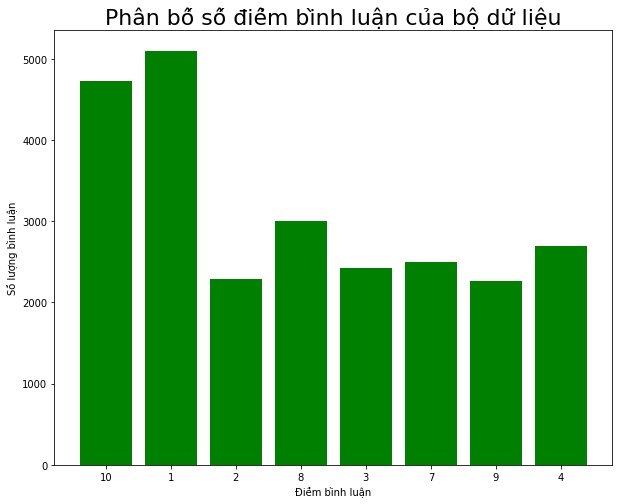

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import os
import collections

Dic_score = {}

for i in reviews_train.filenames:
    filenames = os.path.basename(i)
    temp = filenames.split('_')
    score = (temp[1].split("."))[0]
   
    if score not in Dic_score:
        Dic_score[score] =1
    else:
        Dic_score[score] +=1

plt.figure(figsize = (10,8))
plt.bar(Dic_score.keys(), Dic_score.values(), color='g')
plt.title('Phân bố số điểm bình luận của bộ dữ liệu', size=22)
plt.xlabel('Điểm bình luận')
plt.ylabel('Số lượng bình luận')     
plt.show()

### Ta tách text_train (data) và y_train (nhãn) ra khỏi reviews_train
### Nhãn được thể hiện dưới dạng giá trị 0 và 1 , Trong đó
### 1 : Positive
### 0 : Negative

In [ ]:
# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target
print("Kiểu dữ liệu của text_train: {}".format(type(text_train)))
print("Số lượng dữ liệu của text_train: {}".format(len(text_train)))
reviews_train.target

Kiểu dữ liệu của text_train: <class 'list'>
Số lượng dữ liệu của text_train: 25000


array([1, 0, 1, ..., 0, 0, 0])

### Đọc 5 bình luận và nhãn

In [89]:
label = ['Negative','Positive']
for i in range(0,5):
    print(text_train[i])
    print("--- Label: " + label[y_train[i]] + "---")

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."
--- Label: Positive---
b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. T

### Có thể thấy rằng text_train là một danh sách có độ dài 25.000, trong đó mỗi mục nhập là một chuỗi chứa đánh giá. Ta cũng có thể thấy rằng bài đánh giá có chứa một số ngắt ký hiệu ngắt dòng trong HTML (tag < br />). 
### Mặc dù những điều này không có tác động lớn đến các mô hình học máy , nhưng tốt hơn hết là nên làm sạch dữ liệu và xóa định dạng này trước khi tiến hành:

In [ ]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]
print(text_train[0])


b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.  It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see.   Flawed but honest with a terrible honesty."


### Tập dữ liệu thu thập có số lượng bình luận tiêu cực và tích cực bằng nhau

Samples per class (test): [12500 12500]


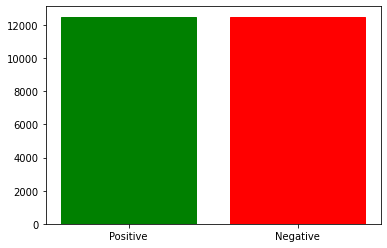

In [ ]:
import collections
print("Samples per class (test): {}".format(np.bincount(y_train)))

count = collections.Counter(y_train)
x = np.array(["Positive", "Negative"])
y = np.array([count[1], count[0]])

barlist = plt.bar(x,y)
barlist[0].set_color('g')
barlist[1].set_color('r')
plt.show()

### Ta làm tương tự với tập dữ liệu test

In [ ]:
from sklearn.datasets import load_files
import numpy as np
reviews_test = load_files("aclImdb_v2/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: {}".format(len(text_test)))
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Number of documents in test data: 25000
Samples per class (test): [12500 12500]
